<a href="https://colab.research.google.com/github/uervitonsantos/Otimizacao-Politicaca-Manutencao-Preventiva-Imperfeita/blob/main/Algoritmo_PSO_para_otimiza%C3%A7%C3%A3o_de_custo_de_manuten%C3%A7%C3%A3o_preventiva_v14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Os Dataset's de dados de confiabilidade para os 4 cenarios podem ser obtidos em: https://drive.google.com/drive/folders/1tzW3424gsRYhvXOCIaF67PCb3PAiOU43?usp=drive_link

In [426]:
%%capture
pip install pyswarms

In [427]:
%%capture
pip install scipy

In [428]:
from scipy import stats
import numpy as np
import pandas as pd
import math
import csv
import locale
import matplotlib.pyplot as plt
import time
from pyswarms.single.global_best import GlobalBestPSO
import pyswarms as ps

In [429]:
!dpkg-reconfigure locales

Generating locales (this might take a while)...
  en_US.UTF-8... done
  pt_BR.ISO-8859-1... done
Generation complete.


In [430]:
# Install locale pt_BR
!/usr/share/locales/install-language-pack pt_BR

Generating locales (this might take a while)...
Generation complete.
dpkg-trigger: error: must be called from a maintainer script (or with a --by-package option)

Type dpkg-trigger --help for help about this utility.


In [431]:
print(locale.getlocale())

('pt_BR', 'ISO8859-1')


In [432]:
locale.setlocale(locale.LC_ALL, 'pt_BR.iso88591')

'pt_BR.iso88591'

In [433]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [434]:
# Constantes criadas para representar alguns valores de teste no codigo

MAX_VALUE_CUSTO = 15000 # Valor maximo para o custo total da otimização
fator_melhoria = 'expo' # Função exponencial selecionada. Há outras funções desenvolvidas
DIAS_OBSERVADOS = 730 # Quantidade de dias observados no horizonte de planejamento. Para cada teste há uma quantidade de dia específico
CMC = 15000 # Valor para o custo da manutenção corretiva
CMP = 2000 # Valor para o custo da manutenção preventiva

VALOR_DIMENSOES = int(DIAS_OBSERVADOS / 30)

ALGORITMO = 'pso'

# Configuraçaõ dos cerarios utulidados para os testes: primeiro_cenario, segundo_cenario, terceiro_cenario, quarto_cenario
CENARIO = 'quarto_cenario'

LINK_ARQUIVO_PRINCIPAL = f'/content/drive/MyDrive/datasets/resultados_optimizacao/resultados_{ALGORITMO}/Resultados_{CENARIO}/'
NOME_ARQUIVO_PRINCIPAL = f'melhor_custo_{ALGORITMO}_{CENARIO}'
NOME_ARQUIVO_TEMPO_SEVERIDADE = 'tempo_severidade'
NOME_ARQUIVO_PARAMETROS = 'parametros'

# Constante para configuração dos cenarios de teste. de 01 a 04
CENARIO_TESTE = f'{CENARIO}'

In [435]:
print(LINK_ARQUIVO_PRINCIPAL)

/content/drive/MyDrive/datasets/resultados_optimizacao/resultados_pso/Resultados_quarto_cenario/


In [436]:
class IntensidadeFalha:
    # Este método vai inicializar cada objeto criado a partir desta classe
    # O nome deste método é "inicio"
    # (self) é uma referência a cada atributo de um objeto criado a partir desta classe
    # Os atributos de cada objeto criados a partir desta classe.
    # O self indica que estes são atributos dos objetos
    def __init__(self):
        self.fator = None
        self.lamb = None
        self.beta = None
        self.theta = None
        self.sz = None
        self.T = None
        self.u = None

    def inicio(self, T, fator, solucao):
        self.fator = fator
        self.lamb = solucao[0]
        self.beta = solucao[1]
        self.theta = solucao[2]
        self.sz = int(T[-1])
        self.T = T

    def create(self):
        self.u = []
        for i in range(len(self.T) - 1):
            for tt in range(int(self.T[i]), int(self.T[i + 1])):
                b = tt - self.fator[0][i] * self.T[i]
                self.u.append((1 / (self.lamb ** self.beta)) * self.beta * b ** (self.beta - 1))
            # Adiciona nan ao final do ciclo
            self.u.append(float('nan'))

    # plota e salva a figura da função de intensidade de falha
    def plotar(self):
        fig = plt.figure(figsize=(20, 5))
        plt.plot(self.u)

        for xc in self.T:
            plt.axvline(x=xc, color='r', linestyle='--')

        plt.xlabel("Tempo (dias)")
        plt.ylabel("Função intensidade de falha")
        plt.xlim(0)
        plt.grid(True)
        plt.show()

In [437]:
# Define a função de melhoria constante
def const(ck, m, s, theta):
    fator = [[theta] * ck] * m
    return fator

In [438]:
# Define a função de melhoria linear
def linear(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = [0]
        for j in range(0, ck, 1):
            linha.append(s[k][j] * theta)
        fator.append(linha)
    return fator

In [439]:
# Define a função de melhoria exponencial
def expo(ck, m, s, theta):
    fator = []
    for k in range(0, m):
        linha = []
        # Verifique se o índice k é válido
        if k >= len(s):
            break
        for j in range(0, ck):
            # Verifique se o índice j é válido
            if j >= len(s[k]):
                break
            linha.append(1.0 - np.exp(-s[k][j] * theta))
        fator.append(linha)

    return fator

In [440]:
# Define a função de melhoria potência
def pot(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(s[k][j] ** theta)
        fator.append(linha)
    return fator

In [441]:
# Define a função de melhoria para manutenção perfeita
def mpp(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(1)
        fator.append(linha)
    return fator

In [442]:
# Executa a função de melhoria com base no parâmetro fornecido
def execute_function(fator_melhoria, ck, m, s, theta):
    return {
        'const': lambda: const(ck, m, s, theta),
        'linear': lambda: linear(ck, m, s, theta),
        'expo': lambda: expo(ck, m, s, theta),
        'pot': lambda: pot(ck, m, s, theta),
        'mpp': lambda: mpp(ck, m, s, theta),
    }[fator_melhoria]()

In [443]:
# Função custo de manutenção baseada severidade
def custo_mp(s, CMP):
    # Dicionario definido pelo cliente
    dist = {1.0: 400.0000}
    custos = [dist.get(si, CMP) for si in s]
    custo_total = np.sum(custos)
    return custo_total

In [444]:
# Função custo de manutenção baseada em severidade
def custo_mp(s, CMP):
    # Dicionario definido pelo cliente
    dist = {0.5: 2000, 1.0: 3000}
    if not isinstance(s, list):
        s = [s]  # Transforma s em uma lista com um único elemento
    cmp_f = np.sum([CMP if si < 0.20 or si > 1.0 else np.interp(si, [0.5, 1.0], [2000, 3000]) for si in s])
    return cmp_f

O 1.º cenário, considera o dataset fictício do trabalho do Dr Marco Coque Jr, com 5 sistema, observados por 600 dias, com MP realizada nos tempos 150, 250, 500 e 600, com custo de MP apresentado na tabela 1, com taxas de severidades de 40%, 50%, 90% e 20%, respectivamente  e MC fixa em "?"

O 2.º cenário, considera o dataset fictício, com 3 sistemas, observados por 730 dias, com MP realizada nos tempos "?", com custo de MP apresentado na tabela 2, com taxas de severidade fixas em 20%, 70% e 100%, respectivamente e MC fixa em US$15.000

O 3.º cenário, considera o dataset fictício, com 2 sistemas, observados por 1.460 dias, com MP realizada nos tempos "?", com custo de MP fixo em US$4.000, com taxas de severidade fixas em 100% e MC fixa em US$17.000

O 4.º cenário, considera o dataset fictício, com 4 sistemas, observados por 730 dias, com MP realizada nos tempos "?", com custo de MP apresentado na tabela 2, com taxas de severidade fixas em 50% e 100%, onde US$2.000 e US$3.000, respectivamente e MC fixa em US$15.000 texto em itálico





In [445]:
# Defina o dicionário de tipos de dados
# define as 3 colunas do dataset como int
dtypes = {
    't': int,
    'k': int,
    'c': int,
}

# Leitura dos dados de tempo de falha para 4 cenarios de exemplo
df = pd.read_csv(f'/content/drive/MyDrive/datasets/Cenarios/{CENARIO_TESTE}.csv', sep=";")

# Remova as linhas com valores ausentes
df = df.fillna(0)

# Converta as colunas para os tipos de dados desejados
df = df.astype(dtypes)

df.head()

,t,k,c,n,s,T
0,1033,1,6,0,1.0,182
1,1309,1,7,0,1.0,366
2,1778,1,7,0,1.0,547
3,2342,1,10,0,1.0,731
4,3254,1,14,0,1.0,912




*   t: Representa os tempos de falha.
*   k: Indica o índice do sistema.
*   c: Representa o número de ciclos de manutenção.
*   n: Indica o número de falhas em cada ciclo de manutenção preventiva.
*   s: Representa a severidade das manutenções preventivas em cada sistema.
*   T: Indica os tempos das manutenções preventivas.



In [446]:
# Cria as variaveis
# tempos de falhas
t = df['t']
# indice do sistema
k = df['k']
m = k.drop_duplicates().shape[0]
# Numero de ciclos de manutenção
ck = df['c'].max()
# Numero de falhas e severidade das manutenções preventivas em cada sistema
n = []
s = []
for k in range(m):
    n.append(list(df['n'][k * ck:(k + 1) * ck]))
    s.append(list(df['s'][k * ck:(k + 1) * ck]))

# Tempos das MP
T = list(df['T'][:m])

In [447]:
# Define a função objetivo para ótimização dos parametros lambda, beta, theta
def objective(x):
    #
    # Solucao a ser avaliada x = [x1, x2, x3] = [lambda, beta, theta]
    lamb = x[:, 0]
    beta = x[:, 1]
    theta = x[:, 2]

    # Cria fator de melhoria
	# variável fator_melhoria definida como 'expo' no início do programa!
    fator = execute_function(fator_melhoria, ck, m, s, theta)

    cont = 0
    fitness = 1

    for k in range(0, m, 1):
        prod = 1
        for j in range(0, len(ck) if isinstance(ck, np.ndarray) else 1, 1):
            nkj = int(n[k][j])
            for i in range(0, nkj, 1):
                prod = prod * (1/(lamb**beta)) * beta * (int(t[cont])-fator[k][j]*T[j])**(beta-1);
                cont = cont + 1;

        soma = 0
        for l in range(0, len(ck) if isinstance(ck, np.ndarray) else 1, 1):
            soma = soma + ((1/(lamb**beta))*(T[l+1]-fator[k][l]*T[l])**beta - (1/(lamb**beta))*(T[l]-fator[k][l]*T[l])**beta);

        ans = np.exp(-soma)
        fitness = fitness * prod * ans;

    return (-1)*fitness

In [448]:
# Parâmetros do PSO
num_particles = 100
max_iterations = 50
dimensions = 3
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}  # Opções do PSO

# Limites inferiores e superiores para lamb, beta e theta
lb = np.array([100, 1, 0])
ub = np.array([150, 2, 1])
bounds = (lb, ub)

# Registre o tempo de início de convergência para a primeira etapa
start_time_first_stage = time.time()

optimizer = GlobalBestPSO(n_particles=num_particles, dimensions=dimensions, options=options, bounds=bounds)

# Registre o tempo de término
end_time_first_stage = time.time()

# Calcule o tempo total de convergência
convergence_time_first_stage = end_time_first_stage - start_time_first_stage

# Define o enxame de partículas
swarm = optimizer.swarm

# Inicializar current_cost e pbest_cost com valores infinitos
swarm.current_cost = np.full(swarm.position.shape[0], np.inf)
swarm.pbest_cost = np.full(swarm.position.shape[0], np.inf)
best_cost, best_position = optimizer.optimize(objective, iters=max_iterations)

# Calcula mask_cost
mask_cost = swarm.current_cost < swarm.pbest_cost

# Atualiza pbest
swarm.pbest_cost = np.where(mask_cost, swarm.current_cost, swarm.pbest_cost)
swarm.pbest_pos = np.where(mask_cost[:, np.newaxis], swarm.position, swarm.pbest_pos)

2024-02-01 00:47:41,091 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|50/50, best_cost=-.0851
2024-02-01 00:47:41,185 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.08510838690468042, best pos: [149.52122296   1.00104579   0.9440704 ]


In [449]:
# Criação de variáveis para os parâmetros
lamb, beta, theta = best_position
print('lamb:', lamb)
print('beta:', beta)
print('theta:', theta)
print('')
print("Tempo de Convergência para a primeira etapa:", convergence_time_first_stage, "segundos")

lamb: 149.52122296096178
beta: 1.0010457855661754
theta: 0.9440703975029663

Tempo de Convergência para a primeira etapa: 0.006286144256591797 segundos


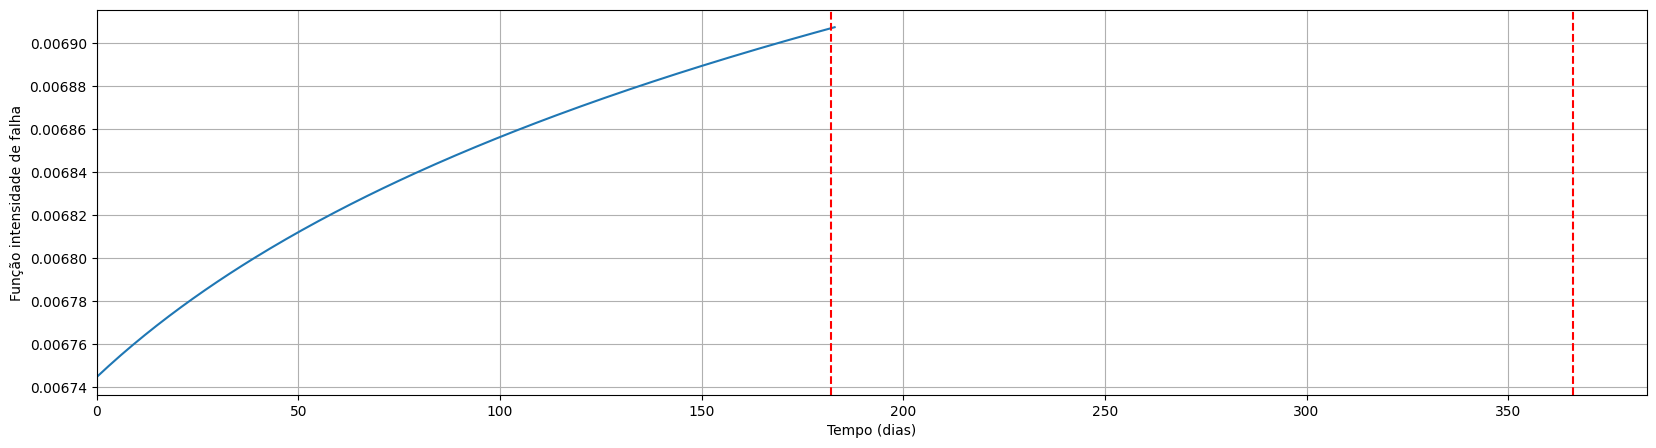

Fator ajuste:  [0.6048420160385737, 0.6048420160385737, 0.6048420160385737, 0.6048420160385737, 0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.6048420160385737, 0.37138407277461827, 0.6048420160385737, 0.37138407277461827, 0.6048420160385737, 0.6048420160385737, 0.6048420160385737]


In [450]:
lamb = 149.00464139548197
beta = 1.0188509450512666
theta = 0.9284696346474378

solucao = [lamb, beta, theta]

# Cria a instância da classe IntensidadeFalha
intensidadeFalha = IntensidadeFalha()

# Inicializa a instância com os valores necessários
intensidadeFalha.inicio(T, execute_function(fator_melhoria, ck, m, s, theta), solucao)

# Cria os dados da intensidade de falha
intensidadeFalha.create()

# Plota o gráfico da intensidade de falha
intensidadeFalha.plotar()

fator = execute_function(fator_melhoria, ck, m, s, theta)
print('Fator ajuste: ', fator[0])

last_value_fator_ajuste = fator[0][-1]

time_duration = 1
time.sleep(time_duration)

In [451]:
# Nome do arquivo CSV para salvar os resultados dos parametros
nome_arquivo_parametros = f'{LINK_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_PARAMETROS}.csv'

In [452]:
# # Gravar os valores de Lambda, Beta e Theta em um arquivo separado
# melhores_parametros = []

# try:
#     with open(nome_arquivo_parametros, 'r') as arquivo_csv:
#         reader = csv.reader(arquivo_csv)
#         next(reader)  # Pule o cabeçalho
#         for linha in reader:
#             melhores_parametros.append(linha[1])
# except FileNotFoundError:
#     pass  # Arquivo não existe, pode ser a primeira execução


# # Criar uma lista com os valores atuais
# valores_atuais = [len(melhores_parametros), lamb, beta, theta, convergence_time_first_stage]

# # Abrir o arquivo CSV em modo de leitura e escrita e escrever os valores atuais no final do arquivo
# with open(nome_arquivo_parametros, 'a+', newline='') as arquivo_csv:
#     writer = csv.writer(arquivo_csv)

#     # Se o arquivo estiver vazio, escreva o cabeçalho
#     if arquivo_csv.tell() == 0:
#         writer.writerow(['Index', 'Lambda', 'Beta', 'Theta', 'Convergencia_Primeira_Etapa'])

#     # Escrever os valores atuais
#     writer.writerow(valores_atuais)

In [453]:
# Leitura dos dados de tempo de falha para 4 cenarios de exemplo
resultado = pd.read_csv(nome_arquivo_parametros, sep=",")
resultado.head(10)

,Index,Lambda,Beta,Theta,Convergencia_Primeira_Etapa
0,0,148.378437,1.000280,0.443913,0.014879
1,1,148.378437,1.000280,0.443913,0.014879
2,2,149.934101,1.002761,0.525065,0.008266
3,3,149.166967,1.009657,0.846362,0.007395


In [454]:
resultado.describe()

,Index,Lambda,Beta,Theta,Convergencia_Primeira_Etapa
count,4.000000,4.000000,4.000000,4.000000,4.000000
mean,1.500000,148.964486,1.003245,0.564813,0.011355
std,1.290994,0.745667,0.004432,0.191558,0.004085
min,0.000000,148.378437,1.000280,0.443913,0.007395
25%,0.750000,148.378437,1.000280,0.443913,0.008048
50%,1.500000,148.772702,1.001521,0.484489,0.011572
75%,2.250000,149.358751,1.004485,0.605389,0.014879
max,3.000000,149.934101,1.009657,0.846362,0.014879


In [455]:
param_primeira_etapa = ['Lambda', 'Beta', 'Theta']
Lambda = ['Lambda']
Beta = ['Beta']
Theta = ['Theta']

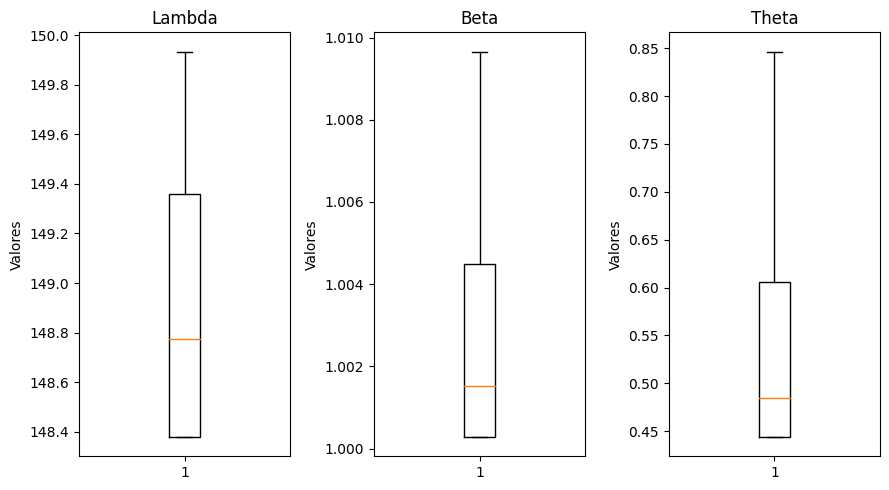

In [456]:
# Cria uma grafico para os parametros Lambda, Beta e Theta
# Tamanho da figura
plt.figure(figsize=(9, 5))

# Itera sobre as colunas e cria um boxplot para cada uma
for i, coluna in enumerate(param_primeira_etapa):
    plt.subplot(1, 3, i + 1)  # 1 linhas, 3 colunas de gráficos
    plt.boxplot(resultado[coluna])
    plt.title(coluna)
    plt.ylabel('Valores')

# Ajusta o layout
plt.tight_layout()
plt.show()

In [457]:
# Configurar a formatação da moeda
def format_currency(value):
    return locale.currency(value, grouping=True)

In [458]:
# Função objetivo para otimização da politica de manutenção
# Numero de ciclos determinado pela solução
# Solução com 24 valores reais
# Solucao a ser avaliada X = [x1, ..., x24]
def objective_st(x):

    # Dicionario para severidades
    dict_severidades = {1:0.5, 3:0, 5:0, 7:1.0}

    results = [] # Lista para armazenar os resultados das funções objetivo

    # No PSO, como cada particula é um vetor de dimenções definidas, é
    # Necessario interar sobre o vetor de particulas
    for particle in x:
        T = [0]
        s_row = []
        cont = 0

        for number in particle:
            modulo = int(number) % 2
            if modulo == 1:
                inteiro = int(number)
                s_row.append(dict_severidades[inteiro])  # Severidade
                frac = number - inteiro  # Tempo
                t = (cont + frac) * 30
                T.append(int(t))
            cont += 1

    s = []
    for row in range(m):
        s.append(s_row)

    # A partir da solução define o número de ciclos
    ck = len(T) - 1

    print("")
    print("=========================================================================")
    print("")
    print('Número de ciclos de manutenção:', ck, m)
    print('Tempos para manutenções preventivas:', T)
    print('Severidade para cada subsistema:', s[0])
    print("Número de Sisemas:", m)

    if ck == 0:
        return MAX_VALUE_CUSTO

    # O modelo já está ajustado
    # Utilizado para avaliar a solução candidata

    # Cria fator de meloria a partir da solução
    fact = execute_function(fator_melhoria, ck, m, s, theta)
    fator = [last_value_fator_ajuste] + list(fact[0])

    print('Fator: ', fator)

    # Numero esperado de falhas (NEF) em cada ciclo
    termos_somatorio = [((1/(lamb**beta)) * (T[1]**beta))]
    numero_medio_falhas = [0, ((1/(lamb**beta)) * (T[1]**beta))]

    for i in range(ck-1):
        termo = (((T[i+2]-fator[i]*T[i+1])**beta) - (((1-fator[i])*T[i+1])**beta)) * (1/(lamb**beta))
        termos_somatorio.append(termo)
        numero_medio_falhas.append(sum(termos_somatorio))

    # Número médio de falhas até o final do período: 2 anos
    final = DIAS_OBSERVADOS
    termo = (((final-fator[ck-1]*T[ck])**beta) - (((1-fator[ck-1])*T[ck])**beta)) * (1/(lamb**beta))
    termos_somatorio.append(termo)
    numero_medio_falhas.append(sum(termos_somatorio))

    mi = numero_medio_falhas

    print('Media de falhas: ', mi)

    Ctotal =  []

    for i in range(ck):
        cmp = custo_mp(s[0][i], CMP)
        Ctotal.append((cmp + (mi[i+1] - mi[i])*CMC)/(T[i+1]-T[i]))

    cmp = custo_mp(s[0][ck-1], CMP)
    Ctotal.append((cmp + (mi[ck+1] - mi[ck])*CMC)/(final-T[ck]))

    # Custo Total
    Custo = np.sum(Ctotal)
    results.append(Custo) # Adicione o valor da função objetivo à lista de resultados
    print('Custo = ', Custo)

    # Retorne os resultados da função objetivo como um array
    return np.array(results)

In [459]:
num_particles = 100
max_iterations = 100
dimensions = VALOR_DIMENSOES
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

max_bound = np.array([1.3] * dimensions)  # Limite superior dos valores em x
min_bound = np.array([0.0] * dimensions)   # Limite inferior dos valores em x
bounds = (min_bound, max_bound)

# Registre o tempo de início de convergência para a segunda etapa
start_time_second_stage = time.time()

optimizer = GlobalBestPSO(n_particles=num_particles, dimensions=dimensions, options=options, bounds=bounds)

# Inicializar current_cost e pbest_cost com valores infinitos
optimizer.swarm.current_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
optimizer.swarm.pbest_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
best_cost, best_position = optimizer.optimize(objective_st, iters=max_iterations)

# Registre o tempo de término
end_time_second_stage = time.time()

# Agora, você pode calcular os outros valores relacionados à melhor solução
# Primeiro, você precisa transformar a melhor posição em uma lista (se necessário)
best_position_list = best_position.tolist()

pbest_cost = optimizer.swarm.pbest_cost

gbest_cost = optimizer.cost_history[-1]  # O último valor registrado no histórico de custos

best_positions = []  # Lista para armazenar todas as melhores posições

# Loop de iterações do PSO
for i in range(max_iterations):
    best_cost, best_position = optimizer.optimize(objective_st, iters=1)
    pbest_cost = optimizer.swarm.pbest_cost
    best_positions.append(best_position)

# Converter a lista de melhores posições em um array numpy para facilitar a manipulação
best_positions = np.array(best_positions)

2024-02-01 00:47:43,043 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:  17%|█▋        |17/100, best_cost=217



Número de ciclos de manutenção: 6 2
Tempos para manutenções preventivas: [0, 67, 334, 488, 514, 546, 632]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.4429262014756649, 2.265838238173819, 3.3316938362801176, 3.5120510591455725, 3.734274700427916, 4.332948362869325, 5.017019970712443]
Custo =  956.1501634033273


Número de ciclos de manutenção: 7 2
Tempos para manutenções preventivas: [0, 124, 275, 306, 395, 421, 541, 664]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.8293120881580519, 1.856994116337804, 2.0698975626133826, 2.6837

pyswarms.single.global_best:  53%|█████▎    |53/100, best_cost=217



Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 152, 215]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 1.0204852573503296, 1.4471635596390737, 5.027973536266119]
Custo =  355.37871178981516


Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 153, 210]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 1.0273259593467066, 1.4131782823955004, 5.028490504064417]
Custo =  358.55193743871905


Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 65, 151, 275, 630]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.42945911040216184, 1.0

pyswarms.single.global_best:  88%|████████▊ |88/100, best_cost=217



Número de ciclos de manutenção: 1 2
Tempos para manutenções preventivas: [0, 157]
Severidade para cada subsistema: [0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827]
Media de falhas:  [0, 1.0546971428935372, 5.0251120384894605]
Custo =  220.93406056289228


Número de ciclos de manutenção: 0 2
Tempos para manutenções preventivas: [0]
Severidade para cada subsistema: []
Número de Sisemas: 2


Número de ciclos de manutenção: 1 2
Tempos para manutenções preventivas: [0, 60]
Severidade para cada subsistema: [0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827]
Media de falhas:  [0, 0.3958260890578502, 5.034711306427156]
Custo =  239.1305694194968


Número de ciclos de manutenção: 1 2
Tempos para manutenções preventivas: [0, 151]
Severidade para cada subsistema: [0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827]
Media de falhas:  [0, 1.0136454036869968, 5.0255040441254355]
Custo =  221.3266782373655


Número de cicl

pyswarms.single.global_best: 100%|██████████|100/100, best_cost=217
2024-02-01 00:47:43,717 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.1318013  0.58090627 1.15420649 0.64295955 0.52052779 1.09781246
 0.31520623 0.07137511 1.01603661 1.10736567 0.835796   0.57995807
 0.61134246 0.98823041 0.70193915 0.15907827 0.10379204 0.62835286
 0.6751948  0.4923725  0.86046667 1.0803857  0.99329148 0.77395667]
2024-02-01 00:47:43,718 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 0 2
Tempos para manutenções preventivas: [0]
Severidade para cada subsistema: []
Número de Sisemas: 2


Número de ciclos de manutenção: 0 2
Tempos para manutenções preventivas: [0]
Severidade para cada subsistema: []
Número de Sisemas: 2


Número de ciclos de manutenção: 0 2
Tempos para manutenções preventivas: [0]
Severidade para cada subsistema: []
Número de Sisemas: 2


Número de ciclos de manutenção: 0 2
Tempos para manutenções preventivas: [0]
Severidade para cada subsistema: []
Número de Sisemas: 2


Número de ciclos de manutenção: 1 2
Tempos para manutenções preventivas: [0, 277]
Severidade para cada subsistema: [0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827]
Media de falhas:  [0, 1.8808586312768643, 5.021006578816015]
Custo =  217.46518693309318


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217
2024-02-01 00:47:43,733 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.1317956  0.58090148 1.15420701 0.64313699 0.51128683 1.09734618
 0.31520623 0.07137512 1.01603655 1.10736582 0.83579966 0.57962379
 0.61133271 0.98823091 0.70203694 0.15908792 0.10379185 0.62798767
 0.6751948  0.49237242 0.86046671 1.08041291 0.99328941 0.77395638]
2024-02-01 00:47:43,734 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 0 2
Tempos para manutenções preventivas: [0]
Severidade para cada subsistema: []
Número de Sisemas: 2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217
2024-02-01 00:47:43,762 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13179649 0.58090376 1.15420644 0.64317637 0.51315171 1.09721853
 0.31520623 0.07137513 1.01603648 1.10736565 0.8357975  0.57992702
 0.61133197 0.98823093 0.70221277 0.1590648  0.1037918  0.62855817
 0.6751948  0.4923734  0.86046665 1.0803943  0.99328718 0.77395638]
2024-02-01 00:47:43,765 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 1 2
Tempos para manutenções preventivas: [0, 64]
Severidade para cada subsistema: [0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827]
Media de falhas:  [0, 0.4227284788611579, 5.034138393408786]
Custo =  237.1905738970695


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217
2024-02-01 00:47:43,780 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13179769 0.58090645 1.15420594 0.6431844  0.51553068 1.09718966
 0.31520623 0.07137514 1.01603643 1.1073655  0.83579538 0.58019996
 0.61133222 0.98823081 0.70231326 0.1590451  0.10379177 0.62902806
 0.6751948  0.49237421 0.86046659 1.08037564 0.99328596 0.77395641]
2024-02-01 00:47:43,786 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 0 2
Tempos para manutenções preventivas: [0]
Severidade para cada subsistema: []
Número de Sisemas: 2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217
2024-02-01 00:47:43,801 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13179888 0.58090883 1.15420564 0.64318014 0.51819619 1.09719522
 0.31520623 0.07137515 1.01603641 1.10736541 0.83579361 0.58041745
 0.61133413 0.98823059 0.70231701 0.15903478 0.10379182 0.62938125
 0.6751948  0.49237451 0.86046654 1.08036137 0.99328606 0.77395645]
2024-02-01 00:47:43,801 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 150, 275]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 1.0068064038686384, 1.8575219088695256, 5.02368082289688]
Custo =  340.8743040135131


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217
2024-02-01 00:47:43,813 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13180033 0.58091029 1.15420542 0.643133   0.52088368 1.09727006
 0.31520623 0.07137514 1.01603641 1.10736538 0.83579217 0.58049669
 0.6113374  0.98823036 0.70226944 0.1590291  0.1037919  0.62965804
 0.6751948  0.49237466 0.86046654 1.0803546  0.99328655 0.77395649]
2024-02-01 00:47:43,814 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 127, 155]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.849758940799944, 1.0381712372836698, 5.032361639360494]
Custo =  396.15152321163276


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217
2024-02-01 00:47:43,826 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13180166 0.58091107 1.1542054  0.64305207 0.52325227 1.09738743
 0.31520623 0.07137513 1.01603645 1.10736538 0.83579098 0.58049115
 0.61134103 0.98823015 0.70219518 0.15903181 0.10379201 0.62960497
 0.6751948  0.49237473 0.86046654 1.08035735 0.99328772 0.77395653]
2024-02-01 00:47:43,827 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 63, 241, 390, 631]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.4159998295888164, 1.6240823083208116, 2.6505773628838565, 4.326010639262671, 5.017058269012742]
Custo =  598.080556800509


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217
2024-02-01 00:47:43,835 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13180284 0.58091154 1.15420553 0.64297677 0.52536677 1.09752195
 0.31520623 0.07137511 1.01603649 1.10736542 0.83579013 0.58036111
 0.6113443  0.98823002 0.70209593 0.15903563 0.10379212 0.62947824
 0.6751948  0.49237431 0.86046657 1.08036528 0.99328922 0.77395658]
2024-02-01 00:47:43,837 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 124, 247, 392, 633]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.8293120881580519, 1.6647394605696646, 2.6638488266523948, 4.339394616806692, 5.016490108860614]
Custo =  589.6497198950633


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217
2024-02-01 00:47:43,845 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13180385 0.58091108 1.15420585 0.64290818 0.52716995 1.09771135
 0.31520623 0.07137509 1.01603655 1.10736552 0.83579058 0.58013677
 0.61134721 0.98823001 0.70200398 0.15904811 0.10379219 0.62907165
 0.6751948  0.49237339 0.86046662 1.08037334 0.9932907  0.77395665]
2024-02-01 00:47:43,846 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 215, 393, 635, 660]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 1.4529158535051285, 2.6725143872795507, 4.355108780118914, 4.529357463763861, 5.0180631667728335]
Custo =  655.0804534072505


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217
2024-02-01 00:47:43,854 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13180441 0.58091057 1.15420624 0.64286166 0.52782068 1.09790111
 0.31520623 0.07137508 1.01603661 1.10736562 0.83579127 0.57991357
 0.61134927 0.98823005 0.70191789 0.15906787 0.10379224 0.62868732
 0.6751948  0.49237239 0.86046666 1.08038149 0.99329211 0.77395672]
2024-02-01 00:47:43,855 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 6 2
Tempos para manutenções preventivas: [0, 63, 124, 155, 394, 636, 660]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.4159998295888164, 0.8249695247572576, 1.0350645085392638, 2.6791889813471066, 4.361839546239937, 4.529119305140607, 5.017825008149579]
Custo =  975.615982647512


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217
2024-02-01 00:47:43,863 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13180456 0.58090901 1.15420666 0.64283279 0.52717414 1.09806349
 0.31520623 0.07137507 1.01603666 1.10736571 0.83579301 0.57972428
 0.61134984 0.98823011 0.70184531 0.15908675 0.10379228 0.62831491
 0.6751948  0.49237152 0.86046671 1.0803894  0.99329336 0.77395676]
2024-02-01 00:47:43,864 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 394, 636, 660]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 2.6931287237495387, 4.366226283308391, 4.533506042209061, 5.0222117452180335]
Custo =  540.7525423529128


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217
2024-02-01 00:47:43,871 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13180449 0.58090729 1.15420699 0.64284042 0.52497024 1.09820761
 0.31520623 0.07137507 1.0160367  1.10736578 0.83579525 0.5796186
 0.61134946 0.98823022 0.70179597 0.15910165 0.10379231 0.62798833
 0.6751948  0.49237093 0.86046674 1.0803961  0.9932944  0.77395679]
2024-02-01 00:47:43,872 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 5 2
Tempos para manutenções preventivas: [0, 126, 246, 393, 635, 660]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.8429423008082217, 1.6579287617699183, 2.670841817728899, 4.353436210568262, 4.527684894213209, 5.016390597222181]
Custo =  782.1279744319282


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217
2024-02-01 00:47:43,879 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13180438 0.58090571 1.15420716 0.64285679 0.52292234 1.0982925
 0.31520623 0.07137507 1.01603673 1.10736583 0.83579731 0.57958532
 0.61134719 0.98823032 0.70178494 0.15911121 0.10379228 0.62770237
 0.6751948  0.49237073 0.86046676 1.08040154 0.99329518 0.77395679]




Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 65, 157, 391, 634]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.42945911040216184, 1.049003363004016, 2.658613598535262, 4.3480877712499835, 5.018207053861932]
Custo =  602.4125645856576


2024-02-01 00:47:43,880 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217
2024-02-01 00:47:43,890 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13180416 0.58090432 1.15420711 0.6428937  0.52073089 1.09832308
 0.31520623 0.07137508 1.01603674 1.10736587 0.83579877 0.57963107
 0.61134424 0.98823043 0.70180434 0.1591151  0.10379221 0.6274769
 0.6751948  0.49237091 0.86046676 1.08040212 0.99329486 0.77395675]
2024-02-01 00:47:43,896 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 390, 632]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 2.6652745785165757, 4.3381785879605905, 5.022250195803709]
Custo =  344.7086271303635


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217
2024-02-01 00:47:43,903 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.1318034  0.58090344 1.15420705 0.64294656 0.51873165 1.09828361
 0.31520623 0.07137509 1.01603675 1.10736584 0.83579961 0.57969451
 0.61134125 0.98823053 0.70183639 0.15911079 0.10379215 0.62745324
 0.6751948  0.49237127 0.86046675 1.0803989  0.99329436 0.77395669]
2024-02-01 00:47:43,903 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 123, 275, 630]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.8224985316354543, 1.8569851422494936, 4.321693537629309, 5.0197170951740295]
Custo =  466.29019549098695


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217
2024-02-01 00:47:43,912 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13180268 0.58090265 1.15420697 0.64299645 0.51730849 1.0981819
 0.31520623 0.0713751  1.01603674 1.10736577 0.83579934 0.57979122
 0.61133879 0.98823061 0.70186593 0.15910143 0.10379206 0.62752825
 0.6751948  0.4923717  0.86046672 1.08039262 0.99329352 0.77395664]
2024-02-01 00:47:43,913 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 67, 211]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.4429262014756649, 1.4179398813484214, 5.026352360690886]
Custo =  352.60908512710034


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217
2024-02-01 00:47:43,924 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13180165 0.58090195 1.15420684 0.64303634 0.51662544 1.09801442
 0.31520623 0.07137511 1.01603673 1.10736569 0.83579819 0.57988937
 0.61133713 0.98823067 0.70190819 0.1590929  0.10379197 0.62776678
 0.6751948  0.49237224 0.86046669 1.08038681 0.9932925  0.7739566 ]
2024-02-01 00:47:43,925 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 0 2
Tempos para manutenções preventivas: [0]
Severidade para cada subsistema: []
Número de Sisemas: 2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217
2024-02-01 00:47:43,938 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13180072 0.5809025  1.15420666 0.64306817 0.51661058 1.09780979
 0.31520623 0.07137512 1.01603669 1.1073656  0.83579702 0.57999165
 0.61133671 0.98823069 0.70195191 0.15908286 0.10379191 0.62815004
 0.6751948  0.4923728  0.86046665 1.08038141 0.99329129 0.77395657]
2024-02-01 00:47:43,941 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 244, 276]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 1.652828200711807, 1.870462286379264, 5.029701503836931]
Custo =  383.1064266956042


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217
2024-02-01 00:47:43,954 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.1317999  0.58090301 1.15420647 0.6430764  0.51748229 1.09762605
 0.31520623 0.07137513 1.01603666 1.10736554 0.83579587 0.58007548
 0.61133771 0.98823066 0.70199009 0.15907276 0.10379187 0.62852444
 0.6751948  0.49237323 0.86046663 1.08037693 0.99329022 0.77395655]
2024-02-01 00:47:43,957 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 1 2
Tempos para manutenções preventivas: [0, 122]
Severidade para cada subsistema: [0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827]
Media de falhas:  [0, 0.8156860192879709, 5.027716743449443]
Custo =  223.88741265533042


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217
2024-02-01 00:47:43,965 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13179946 0.58090417 1.1542063  0.64307627 0.51915038 1.09749539
 0.31520623 0.07137513 1.01603662 1.1073655  0.83579485 0.58014089
 0.61133888 0.9882306  0.70201567 0.15906422 0.10379187 0.62885624
 0.6751948  0.49237352 0.8604666  1.08037551 0.99328947 0.77395655]
2024-02-01 00:47:43,966 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 0 2
Tempos para manutenções preventivas: [0]
Severidade para cada subsistema: []
Número de Sisemas: 2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217
2024-02-01 00:47:43,973 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13179926 0.58090554 1.15420616 0.64306459 0.52078468 1.09739972
 0.31520623 0.07137513 1.01603659 1.10736549 0.83579415 0.58015057
 0.6113402  0.98823051 0.70203701 0.15905676 0.10379188 0.6290624
 0.6751948  0.4923736  0.86046659 1.08037466 0.99328901 0.77395655]
2024-02-01 00:47:43,974 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 215, 631]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 1.4529158535051285, 4.328515126437625, 5.019562756187696]
Custo =  344.069920538067


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217



Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 390, 633]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 2.6652745785165757, 4.345143660243155, 5.022239152297076]
Custo =  344.88888600705695



2024-02-01 00:47:43,982 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13179966 0.58090683 1.15420604 0.64302435 0.5222494  1.09741472
 0.31520623 0.07137513 1.01603656 1.10736552 0.83579358 0.58010183
 0.61134141 0.98823041 0.70203109 0.15905373 0.10379192 0.62915083
 0.6751948  0.49237363 0.86046658 1.08037598 0.99328873 0.77395655]
2024-02-01 00:47:43,983 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217
2024-02-01 00:47:43,990 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13180042 0.58090785 1.15420606 0.64298618 0.52350088 1.09744789
 0.31520623 0.07137512 1.01603654 1.10736557 0.83579363 0.58001785
 0.6113426  0.98823032 0.70200254 0.15905755 0.103792   0.62904711
 0.6751948  0.49237333 0.86046658 1.08037959 0.99328856 0.77395659]
2024-02-01 00:47:43



Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 128, 391, 634]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.8565765926889788, 2.658192877652046, 4.347667050366767, 5.017786332978716]
Custo =  464.4218658008523


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217



Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 63, 391, 635]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.4159998295888164, 2.6616226881496186, 4.358089559829786, 5.0212325395758555]
Custo =  477.8344738833654



2024-02-01 00:47:44,001 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13180117 0.58090833 1.15420621 0.64294796 0.52424754 1.09751328
 0.31520623 0.07137511 1.01603653 1.10736563 0.83579414 0.57992966
 0.61134366 0.98823024 0.70197096 0.15906352 0.10379208 0.62884437
 0.6751948  0.49237304 0.86046659 1.08038377 0.99328868 0.77395663]
2024-02-01 00:47:44,006 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217
2024-02-01 00:47:44,016 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13180186 0.58090867 1.15420638 0.64291459 0.52447231 1.09763399
 0.31520623 0.07137511 1.01603653 1.1073657  0.83579491 0.57985267
 0.61134461 0.98823017 0.70193441 0.15907228 0.10379214 0.62863576
 0.6751948  0.49237278 0.8604666  1.08038796 0.9932896  0.77395667]
2024-02-01 00:47:44



Número de ciclos de manutenção: 5 2
Tempos para manutenções preventivas: [0, 152, 217, 242, 390, 635]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 1.0204852573503296, 1.4607918411892375, 1.631728885727135, 2.651350943419441, 4.354753796685737, 5.017896776431806]
Custo =  783.8705865564854


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217
2024-02-01 00:47:44,025 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13180235 0.58090851 1.15420656 0.64289737 0.52451283 1.09775256
 0.31520623 0.0713751  1.01603653 1.10736575 0.83579574 0.57979643
 0.61134537 0.98823012 0.70190195 0.15908061 0.10379219 0.62843217
 0.6751948  0.49237254 0.86046662 1.08039141 0.99329081 0.77395671]
2024-02-01 00:47:44,026 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 64, 390, 635]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.4227284788611579, 2.6545858097192063, 4.357988662985502, 5.0211316427315715]
Custo =  477.36743229913895


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217
2024-02-01 00:47:44,039 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13180261 0.58090772 1.15420671 0.64289824 0.52375537 1.09787227
 0.31520623 0.07137509 1.01603655 1.10736578 0.83579651 0.57976089
 0.61134568 0.98823008 0.70188078 0.15908774 0.10379222 0.62823638
 0.6751948  0.49237232 0.86046665 1.08039325 0.99329208 0.77395674]
2024-02-01 00:47:44,040 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 125, 156, 635]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.8361266805929285, 1.04476296467543, 4.36471816214162, 5.02786114188769]
Custo =  515.7043486627427


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217



Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 62, 634]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.4092731934545361, 4.359638970293055, 5.029758252905004]
Custo =  363.9052554817995



2024-02-01 00:47:44,055 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13180246 0.58090699 1.15420682 0.64290517 0.52286802 1.09796439
 0.31520623 0.07137509 1.01603657 1.10736578 0.83579708 0.57975766
 0.61134563 0.98823004 0.70187326 0.15909397 0.10379224 0.62806573
 0.6751948  0.49237215 0.86046668 1.08039453 0.99329316 0.77395675]
2024-02-01 00:47:44,057 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217
2024-02-01 00:47:44,065 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.1318021  0.5809063  1.15420691 0.64292618 0.52158729 1.09802648
 0.31520623 0.07137509 1.01603659 1.10736578 0.83579744 0.57977397
 0.61134477 0.98823009 0.70188068 0.15909864 0.10379225 0.62797045
 0.6751948  0.49237205 0.8604667  1.08039333 0.99329379 0.77395674]




Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 155, 212, 632]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 1.0410098866463862, 1.4269288296830438, 4.3404817818387125, 5.024553389681831]
Custo =  484.22182248876345


2024-02-01 00:47:44,067 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217



Número de ciclos de manutenção: 1 2
Tempos para manutenções preventivas: [0, 631]
Severidade para cada subsistema: [0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827]
Media de falhas:  [0, 4.351569180763475, 5.037383637222936]
Custo =  230.72746584421967



2024-02-01 00:47:44,079 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13180167 0.58090568 1.15420692 0.64295343 0.52018191 1.09803096
 0.31520623 0.07137509 1.01603661 1.10736577 0.83579734 0.57983959
 0.61134347 0.98823016 0.70189659 0.15909974 0.10379225 0.62797658
 0.6751948  0.49237196 0.86046672 1.08039166 0.99329402 0.77395673]
2024-02-01 00:47:44,080 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217
2024-02-01 00:47:44,099 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13180122 0.58090514 1.15420691 0.64297847 0.51897283 1.09799184
 0.31520623 0.07137509 1.01603663 1.10736575 0.83579719 0.57992245
 0.61134202 0.98823025 0.70192109 0.15909926 0.10379222 0.62807881
 0.6751948  0.49237191 0.86046673 1.0803887  0.99329416 0.77395671]




Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 127, 152, 242, 630]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.849758940799944, 1.017913389295376, 1.6324298036277387, 4.325053706466749, 5.023077264011469]
Custo =  655.6020121431471


2024-02-01 00:47:44,100 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217
2024-02-01 00:47:44,114 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13180082 0.58090476 1.15420683 0.64300052 0.51789463 1.09795194
 0.31520623 0.0713751  1.01603665 1.10736572 0.83579679 0.5799979
 0.61134083 0.98823036 0.70194759 0.15909688 0.10379217 0.62822867
 0.6751948  0.49237189 0.86046672 1.08038586 0.99329367 0.77395668]
2024-02-01 00:47:44,117 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 60, 120]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.3958260890578502, 0.7978435924739484, 5.0323875160913065]
Custo =  373.53438257902326


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217
2024-02-01 00:47:44,124 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13180048 0.58090479 1.15420671 0.64300935 0.51734667 1.09787929
 0.31520623 0.07137511 1.01603666 1.10736568 0.83579641 0.58006321
 0.61134008 0.98823046 0.70197046 0.15909224 0.10379209 0.62837684
 0.6751948  0.49237192 0.8604667  1.08038326 0.99329273 0.77395666]




Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 248, 275]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 1.6804387645326393, 1.8640423019546244, 5.030201215981979]
Custo =  394.5544665339358


2024-02-01 00:47:44,125 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217
2024-02-01 00:47:44,134 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13180027 0.58090505 1.15420659 0.64301007 0.51717967 1.09780233
 0.31520623 0.07137512 1.01603666 1.10736565 0.83579597 0.58009729
 0.61134002 0.98823055 0.70199104 0.15908403 0.10379202 0.62850326
 0.6751948  0.49237211 0.86046668 1.08038099 0.9932917  0.77395664]
2024-02-01 00:47:44,135 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 66, 630]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.43619169428355453, 4.331052877608163, 5.029076435152883]
Custo =  361.2738727981124


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217
2024-02-01 00:47:44,145 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13180025 0.58090548 1.15420647 0.64300768 0.51770191 1.09773454
 0.31520623 0.07137512 1.01603666 1.10736563 0.83579558 0.58011807
 0.61134006 0.9882306  0.70200498 0.15907569 0.10379196 0.62860443
 0.6751948  0.4923723  0.86046665 1.08037906 0.99329077 0.77395663]
2024-02-01 00:47:44,150 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 211, 246, 276, 630]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 1.4253801602303866, 1.6629245954328105, 1.8685531585384663, 4.326350379087025, 5.024373936631745]
Custo =  673.7347806054463


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217
2024-02-01 00:47:44,164 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13180024 0.58090592 1.15420637 0.64299846 0.51839705 1.09769613
 0.31520623 0.07137513 1.01603666 1.10736561 0.83579525 0.58013063
 0.61134013 0.98823063 0.70199962 0.15906871 0.10379193 0.62865615
 0.6751948  0.49237246 0.86046664 1.08037795 0.99328998 0.77395662]
2024-02-01 00:47:44,165 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 1 2
Tempos para manutenções preventivas: [0, 630]
Severidade para cada subsistema: [0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827]
Media de falhas:  [0, 4.3445429777339175, 5.037288266604419]
Custo =  230.52789597503354


pyswarms.single.global_best:   0%|          |0/1, best_cost=217



Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 61, 272, 631]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.40254860231409356, 1.8376957087710666, 4.330139172147379, 5.02118680189745]
Custo =  477.89592422392013


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217
2024-02-01 00:47:44,183 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13180049 0.58090636 1.15420628 0.6429809  0.51905631 1.09769468
 0.31520623 0.07137513 1.01603665 1.10736561 0.83579502 0.58012248
 0.61134086 0.98823065 0.70198038 0.1590629  0.10379191 0.62863885
 0.6751948  0.49237262 0.86046663 1.08037846 0.99328959 0.77395663]
2024-02-01 00:47:44,184 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217



Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 156, 211, 631]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 1.0478531012772285, 1.4201904841327817, 4.333626635862276, 5.024674265612347]
Custo =  485.20521645968535



2024-02-01 00:47:44,198 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13180071 0.58090674 1.15420623 0.64296319 0.51990949 1.09769548
 0.31520623 0.07137512 1.01603663 1.10736562 0.835795   0.58008897
 0.61134159 0.98823062 0.70195387 0.15906183 0.10379191 0.62860599
 0.6751948  0.49237275 0.86046663 1.08038035 0.99328929 0.77395665]
2024-02-01 00:47:44,200 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217
2024-02-01 00:47:44,214 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13180092 0.58090707 1.15420622 0.64294666 0.52075405 1.09771892
 0.31520623 0.07137511 1.01603661 1.10736563 0.83579508 0.58003984
 0.61134246 0.98823056 0.70192959 0.15906396 0.10379192 0.62853455
 0.6751948  0.49237281 0.86046662 1.08038276 0.99328942 0.77395667]




Número de ciclos de manutenção: 1 2
Tempos para manutenções preventivas: [0, 632]
Severidade para cada subsistema: [0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827]
Media de falhas:  [0, 4.358595593702067, 5.037479273795807]
Custo =  230.93116781888867


2024-02-01 00:47:44,215 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217



Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 66, 390, 632]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.43619169428355453, 2.654415220614574, 4.336840485911831, 5.02091209375495]
Custo =  475.9659011859279



2024-02-01 00:47:44,229 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13180113 0.58090717 1.15420629 0.64293528 0.52147843 1.09774872
 0.31520623 0.07137511 1.01603659 1.10736565 0.83579518 0.5799749
 0.61134325 0.98823049 0.70190949 0.15906821 0.10379194 0.62842626
 0.6751948  0.4923728  0.86046662 1.08038562 0.99328997 0.77395669]
2024-02-01 00:47:44,233 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217
2024-02-01 00:47:44,243 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13180132 0.58090718 1.15420636 0.64293011 0.52193876 1.09778315
 0.31520623 0.0713751  1.01603658 1.10736567 0.83579541 0.57991165
 0.61134379 0.98823042 0.70189559 0.15907362 0.10379198 0.62832092
 0.6751948  0.4923727  0.86046664 1.08038823 0.99329052 0.77395671]
2024-02-01 00:47:44,



Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 390, 633]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 2.6652745785165757, 4.345143660243155, 5.022239152297076]
Custo =  344.88888600705695


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217
2024-02-01 00:47:44,253 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.1318015  0.58090711 1.15420645 0.64292856 0.52211163 1.09782288
 0.31520623 0.0713751  1.01603658 1.10736569 0.83579565 0.57986773
 0.61134414 0.98823036 0.7018899  0.15907978 0.10379203 0.62823123
 0.6751948  0.4923726  0.86046666 1.08039045 0.99329119 0.77395671]
2024-02-01 00:47:44,254 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 217, 633]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 1.4666873334002506, 4.342468094611147, 5.019563586665068]
Custo =  344.42626221986154


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217
2024-02-01 00:47:44,264 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13180163 0.58090699 1.15420654 0.64292953 0.52213207 1.09785708
 0.31520623 0.07137509 1.01603658 1.10736571 0.83579597 0.57985345
 0.61134434 0.98823031 0.7018928  0.15908519 0.10379208 0.62815823
 0.6751948  0.49237249 0.86046667 1.08039214 0.99329183 0.77395672]
2024-02-01 00:47:44,265 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 247, 633]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 1.6735353311989145, 4.342095905778196, 5.019191397832118]
Custo =  343.93479904330263


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217



Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 60, 633]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.3958260890578502, 4.35288515070308, 5.0299806427570015]
Custo =  364.6922357078563



2024-02-01 00:47:44,279 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.1318017  0.58090678 1.15420661 0.64293385 0.52189536 1.09787973
 0.31520623 0.07137509 1.0160366  1.10736572 0.83579626 0.57984357
 0.61134396 0.98823029 0.70190102 0.15908846 0.10379212 0.62814753
 0.6751948  0.4923724  0.86046669 1.08039363 0.99329234 0.77395671]
2024-02-01 00:47:44,281 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217
2024-02-01 00:47:44,298 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.1318017  0.58090658 1.15420668 0.64293986 0.52164458 1.09788546
 0.31520623 0.07137509 1.01603661 1.10736573 0.83579648 0.57984222
 0.61134363 0.9882303  0.70191528 0.15909006 0.10379213 0.62815191
 0.6751948  0.49237231 0.86046671 1.08039356 0.99329259 0.7739567 ]




Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 210, 633]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 1.4184977671033296, 4.3426133630131005, 5.019708855067022]
Custo =  344.5892985614511


2024-02-01 00:47:44,302 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217
2024-02-01 00:47:44,325 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.1318016  0.58090636 1.15420673 0.64294871 0.52135883 1.09788632
 0.31520623 0.0713751  1.01603662 1.10736574 0.83579666 0.57984584
 0.61134301 0.98823034 0.70193253 0.15909048 0.10379213 0.62817668
 0.6751948  0.49237227 0.86046671 1.08039286 0.9932926  0.77395668]
2024-02-01 00:47:44,326 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 217, 633]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 1.4666873334002506, 4.342468094611147, 5.019563586665068]
Custo =  344.42626221986154


pyswarms.single.global_best:   0%|          |0/1, best_cost=217



Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 60, 632]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.3958260890578502, 4.345866350550649, 5.029937958393767]
Custo =  364.4843321870704


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217
2024-02-01 00:47:44,342 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13180145 0.58090617 1.15420673 0.64295957 0.52108295 1.09787487
 0.31520623 0.0713751  1.01603663 1.10736573 0.83579671 0.57985816
 0.61134235 0.98823038 0.70194853 0.15908851 0.1037921  0.6282387
 0.6751948  0.49237229 0.8604667  1.08039111 0.9932924  0.77395667]
2024-02-01 00:47:44,343 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217
2024-02-01 00:47:44,350 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13180127 0.58090599 1.15420668 0.64296933 0.52067597 1.09785537
 0.31520623 0.07137511 1.01603663 1.10736571 0.83579655 0.57989801
 0.61134178 0.98823043 0.70196131 0.1590863  0.10379207 0.62832261
 0.6751948  0.49237232 0.



Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 241, 632]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 1.6321258691610092, 4.3351468767187775, 5.019218484561896]
Custo =  343.80790165734027


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217
2024-02-01 00:47:44,361 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13180112 0.58090587 1.15420659 0.6429757  0.52029239 1.0978267
 0.31520623 0.07137511 1.01603664 1.10736569 0.83579639 0.57994245
 0.61134139 0.98823047 0.70196633 0.15908253 0.10379203 0.62840093
 0.6751948  0.49237237 0.86046668 1.08038709 0.99329158 0.77395664]




Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 212, 271, 632]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 1.432263168266882, 1.833522889879824, 4.339880025416208, 5.023951633259326]
Custo =  481.4822565779346


2024-02-01 00:47:44,362 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217
2024-02-01 00:47:44,370 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13180101 0.58090586 1.15420649 0.64297881 0.51995292 1.09779715
 0.31520623 0.07137512 1.01603664 1.10736566 0.83579621 0.57998635
 0.61134131 0.98823048 0.70196686 0.15907864 0.103792   0.62846665
 0.6751948  0.49237242 0.86046666 1.08038518 0.99329121 0.77395664]
2024-02-01 00:47:44,371 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 62, 156, 242, 631]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.4092731934545361, 1.0422008130722187, 1.6294642772267134, 4.329094043388534, 5.020141673138605]
Custo =  613.383373398797


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217
2024-02-01 00:47:44,398 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13180098 0.58090591 1.1542064  0.6429801  0.5198133  1.0977723
 0.31520623 0.07137512 1.01603663 1.10736564 0.83579602 0.58002055
 0.61134152 0.98823049 0.70196631 0.15907505 0.10379198 0.62849957
 0.6751948  0.49237249 0.86046665 1.08038353 0.9932909  0.77395664]




Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 275, 631]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 1.8670233686621232, 4.3281200469622565, 5.019167676712327]
Custo =  343.33244336786805


2024-02-01 00:47:44,402 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217



Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 240, 631]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 1.6252261684958105, 4.328163469538519, 5.01921109928859]
Custo =  343.6245117492472



2024-02-01 00:47:44,417 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13180101 0.58090599 1.15420634 0.64297954 0.51978993 1.0977522
 0.31520623 0.07137512 1.01603663 1.10736562 0.83579585 0.58004264
 0.61134183 0.98823048 0.70196341 0.15907233 0.10379197 0.62850284
 0.6751948  0.49237255 0.86046665 1.08038264 0.99329062 0.77395665]
2024-02-01 00:47:44,419 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217
2024-02-01 00:47:44,430 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13180104 0.58090613 1.15420634 0.64297347 0.51987896 1.09775179
 0.31520623 0.07137512 1.01603662 1.10736561 0.8357957  0.58004511
 0.61134213 0.98823046 0.70195384 0.15907007 0.10379198 0.6285014
 0.6751948  0.4923726  0.86046665 1.0803822  0.9932904  0.77395666]




Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 61, 275, 631]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.40254860231409356, 1.8583884377114839, 4.330099668721041, 5.021147298471112]
Custo =  477.8342093326417


2024-02-01 00:47:44,433 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217
2024-02-01 00:47:44,445 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13180115 0.5809063  1.15420637 0.64296497 0.5199616  1.09776423
 0.31520623 0.07137511 1.01603661 1.10736562 0.83579562 0.58002494
 0.61134249 0.98823044 0.70194171 0.15906848 0.10379201 0.62847984
 0.6751948  0.49237261 0.86046665 1.08038183 0.99329045 0.77395667]
2024-02-01 00:47:44,447 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 213, 632]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 1.4391467883668296, 4.335551779740159, 5.019623387583278]
Custo =  344.31422378861265


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217
2024-02-01 00:47:44,464 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13180127 0.58090645 1.15420641 0.64295585 0.52007271 1.09777635
 0.31520623 0.07137511 1.0160366  1.10736563 0.83579559 0.58000539
 0.61134281 0.98823041 0.70193005 0.15906876 0.10379204 0.62842953
 0.6751948  0.49237262 0.86046666 1.08038211 0.9932908  0.77395667]
2024-02-01 00:47:44,468 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 151, 272, 632]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 1.0136454036869968, 1.8369621189625716, 4.336408945143525, 5.020480552986643]
Custo =  467.3434408805517


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217



Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 67, 632]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.4429262014756649, 4.3449630087314715, 5.02903461657459]
Custo =  361.2600504356733



2024-02-01 00:47:44,484 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13180138 0.58090655 1.15420645 0.64294824 0.52024789 1.09778859
 0.31520623 0.07137511 1.0160366  1.10736565 0.83579559 0.57997377
 0.61134304 0.98823038 0.70192069 0.15907102 0.10379207 0.6283842
 0.6751948  0.49237259 0.86046667 1.08038338 0.99329118 0.77395668]
2024-02-01 00:47:44,486 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217
2024-02-01 00:47:44,499 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13180145 0.58090656 1.15420649 0.64294332 0.52043685 1.09780114
 0.31520623 0.07137511 1.01603659 1.10736567 0.83579567 0.57994148
 0.61134321 0.98823036 0.70191529 0.15907417 0.10379208 0.62833949
 0.6751948  0.49237255 0.86046668 1.08038504 0.9932916  0.77395669]




Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 156, 213, 632]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 1.0478531012772285, 1.4338051230341808, 4.340465641287778, 5.024537249130896]
Custo =  484.1729895420256


2024-02-01 00:47:44,504 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217
2024-02-01 00:47:44,521 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13180151 0.5809065  1.15420653 0.64294216 0.52063144 1.09781396
 0.31520623 0.07137511 1.01603659 1.10736568 0.83579583 0.57991632
 0.61134324 0.98823035 0.70191187 0.15907733 0.10379209 0.62830162
 0.6751948  0.49237251 0.86046669 1.0803866  0.99329195 0.77395669]
2024-02-01 00:47:44,522 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 1 2
Tempos para manutenções preventivas: [0, 632]
Severidade para cada subsistema: [0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827]
Media de falhas:  [0, 4.358595593702067, 5.037479273795807]
Custo =  230.93116781888867


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217
2024-02-01 00:47:44,534 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13180152 0.58090638 1.15420657 0.64294417 0.52078069 1.09782513
 0.31520623 0.0713751  1.0160366  1.10736569 0.83579598 0.57990467
 0.61134311 0.98823036 0.70191498 0.15908039 0.10379209 0.62826763
 0.6751948  0.49237247 0.8604667  1.08038788 0.99329223 0.77395669]
2024-02-01 00:47:44,538 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 157, 632]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 1.0546971428935372, 4.337507515135732, 5.02157912297885]
Custo =  346.49731993660635


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217
2024-02-01 00:47:44,550 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13180148 0.58090624 1.1542066  0.64294691 0.52087767 1.09783433
 0.31520623 0.07137511 1.0160366  1.1073657  0.83579612 0.57990751
 0.61134294 0.98823037 0.70192374 0.15908305 0.10379208 0.62825254
 0.6751948  0.49237245 0.8604667  1.0803884  0.99329239 0.77395669]
2024-02-01 00:47:44,551 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 65, 215, 632]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.42945911040216184, 1.445425106376306, 4.338299718536553, 5.022371326379671]
Custo =  478.7745143718361


pyswarms.single.global_best:   0%|          |0/1, best_cost=217



Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 156, 248, 632]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 1.0478531012772285, 1.6727059917226947, 4.337924629343638, 5.021996237186756]
Custo =  471.6243753728022


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217
2024-02-01 00:47:44,572 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13180143 0.58090612 1.15420661 0.64295179 0.52089501 1.09783899
 0.31520623 0.07137511 1.01603661 1.1073657  0.83579622 0.57991007
 0.61134269 0.98823039 0.70193243 0.15908516 0.10379207 0.62824909
 0.6751948  0.49237242 0.8604667  1.08038806 0.99329251 0.77395668]
2024-02-01 00:47:44,573 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217
2024-02-01 00:47:44,588 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13180136 0.58090604 1.15420662 0.64295709 0.52089023 1.09784184
 0.31520623 0.07137511 1.01603661 1.1073657  0.83579627 0.57991971
 0.61134246 0.98823041 0.70194224 0.15908682 0.10379207 0.62825268
 0.6751948  0.4923724  0



Número de ciclos de manutenção: 1 2
Tempos para manutenções preventivas: [0, 632]
Severidade para cada subsistema: [0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827]
Media de falhas:  [0, 4.358595593702067, 5.037479273795807]
Custo =  230.93116781888867


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217
2024-02-01 00:47:44,605 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13180129 0.58090603 1.15420659 0.64296229 0.52085634 1.0978375
 0.31520623 0.07137511 1.01603662 1.1073657  0.83579627 0.57993361
 0.61134224 0.98823043 0.70195069 0.15908725 0.10379206 0.62825861
 0.6751948  0.4923724  0.86046669 1.08038596 0.99329251 0.77395668]
2024-02-01 00:47:44,606 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 66, 153, 632]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.43619169428355453, 1.0217865419198278, 4.341305157460222, 5.02537676530334]
Custo =  486.63052987876176


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217
2024-02-01 00:47:44,621 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13180123 0.58090607 1.15420654 0.6429667  0.52082529 1.09782928
 0.31520623 0.07137511 1.01603662 1.10736569 0.83579621 0.57994681
 0.61134205 0.98823045 0.70195668 0.15908536 0.10379205 0.62826488
 0.6751948  0.4923724  0.86046668 1.08038492 0.99329214 0.77395667]
2024-02-01 00:47:44,626 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 247, 632]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 1.6735353311989145, 4.335104883477297, 5.019176491320415]
Custo =  343.7341876862561


pyswarms.single.global_best:   0%|          |0/1, best_cost=217



Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 216, 632]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 1.4598012929824011, 4.335491406189933, 5.019563014033051]
Custo =  344.24579183218344


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217
2024-02-01 00:47:44,639 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13180119 0.58090615 1.1542065  0.64297051 0.52077872 1.09781814
 0.31520623 0.07137511 1.01603662 1.10736569 0.83579613 0.57996084
 0.61134198 0.98823045 0.70196159 0.15908188 0.10379204 0.62829264
 0.6751948  0.49237243 0.86046667 1.08038421 0.99329162 0.77395667]
2024-02-01 00:47:44,640 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217
2024-02-01 00:47:44,654 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13180117 0.58090625 1.15420646 0.64297217 0.52070891 1.09780717
 0.31520623 0.07137512 1.01603662 1.10736568 0.83579606 0.57997265
 0.61134199 0.98823045 0.70196259 0.15907816 0.10379203 0.6283328
 0.6751948  0.49237246 0.



Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 61, 632]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.40254860231409356, 4.345733341714733, 5.029804949557851]
Custo =  363.9761637674951


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217
2024-02-01 00:47:44,678 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13180117 0.58090634 1.15420643 0.64297342 0.52060795 1.09779782
 0.31520623 0.07137511 1.01603662 1.10736567 0.83579598 0.57998005
 0.61134207 0.98823045 0.70195793 0.15907484 0.10379203 0.62837273
 0.6751948  0.4923725  0.86046666 1.08038324 0.99329079 0.77395666]
2024-02-01 00:47:44,679 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 210, 242, 273, 632]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 1.4184977671033296, 1.6356063176081337, 1.8480408400969002, 4.340577092548603, 5.0246487003917215]
Custo =  677.2507392689765


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217
2024-02-01 00:47:44,689 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.1318012  0.58090642 1.15420642 0.64297313 0.52051143 1.09779373
 0.31520623 0.07137511 1.01603662 1.10736566 0.83579592 0.57998585
 0.6113422  0.98823044 0.70195126 0.15907192 0.10379202 0.6284049
 0.6751948  0.49237254 0.86046666 1.08038332 0.9932906  0.77395666]
2024-02-01 00:47:44,689 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 1 2
Tempos para manutenções preventivas: [0, 632]
Severidade para cada subsistema: [0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827]
Media de falhas:  [0, 4.358595593702067, 5.037479273795807]
Custo =  230.93116781888867


pyswarms.single.global_best:   0%|          |0/1, best_cost=217



Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 277, 632]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 1.8808586312768643, 4.3351182261568715, 5.01918983399999]
Custo =  343.5196806968492


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217
2024-02-01 00:47:44,704 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13180125 0.58090648 1.15420642 0.64297139 0.5204273  1.09779546
 0.31520623 0.07137511 1.01603661 1.10736565 0.83579587 0.5799842
 0.61134236 0.98823042 0.70194228 0.15907097 0.10379202 0.62842564
 0.6751948  0.49237256 0.86046666 1.08038399 0.99329055 0.77395667]
2024-02-01 00:47:44,707 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217



Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 215, 243, 632]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 1.4529158535051285, 1.6428885895103633, 4.342622335826574, 5.0266939436696925]
Custo =  518.2254609853371



2024-02-01 00:47:44,718 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.1318013  0.58090648 1.15420643 0.64296904 0.52035395 1.09780112
 0.31520623 0.07137511 1.01603661 1.10736565 0.83579585 0.57998214
 0.61134253 0.98823041 0.70193415 0.15907127 0.10379202 0.62843665
 0.6751948  0.49237258 0.86046666 1.08038478 0.99329067 0.77395667]
2024-02-01 00:47:44,722 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=217



Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 154, 632]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 1.0341675042355771, 4.337660705513647, 5.0217323133567655]
Custo =  346.68082031042445


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217
2024-02-01 00:47:44,758 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13180134 0.58090645 1.15420646 0.64296605 0.52030451 1.09780759
 0.31520623 0.07137511 1.01603661 1.10736565 0.83579583 0.5799774
 0.61134268 0.9882304  0.70192724 0.15907164 0.10379203 0.62844227
 0.6751948  0.4923726  0.86046667 1.08038577 0.99329084 0.77395667]
2024-02-01 00:47:44,760 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217



Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 63, 210, 632]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.4159998295888164, 1.411199722742158, 4.338536495519254, 5.022608103362372]
Custo =  479.85465455177336



2024-02-01 00:47:44,771 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13180137 0.58090636 1.15420648 0.64296234 0.52030162 1.09781461
 0.31520623 0.07137511 1.0160366  1.10736565 0.83579584 0.57996936
 0.6113428  0.98823039 0.70192375 0.15907237 0.10379203 0.62843391
 0.6751948  0.49237259 0.86046667 1.08038664 0.99329118 0.77395667]
2024-02-01 00:47:44,772 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217
2024-02-01 00:47:44,779 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13180138 0.58090628 1.1542065  0.64295896 0.52034402 1.09782089
 0.31520623 0.07137511 1.0160366  1.10736565 0.83579588 0.57996073
 0.61134289 0.98823039 0.70192482 0.15907388 0.10379204 0.62842397
 0.6751948  0.49237256 0.86046667 1.08038738 0.99329151 0.77395668]
2024-02-01 00:47:44



Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 243, 632]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 1.6459268874483701, 4.335131174589316, 5.019202782432434]
Custo =  343.7820906129202


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217



Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 276, 632]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 1.873940763730055, 4.335111959376764, 5.019183567219883]
Custo =  343.5229957890609



2024-02-01 00:47:44,786 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13180138 0.5809062  1.15420652 0.64295603 0.52043691 1.09782566
 0.31520623 0.07137511 1.0160366  1.10736566 0.83579594 0.57995234
 0.61134284 0.98823039 0.70192969 0.15907594 0.10379204 0.62840418
 0.6751948  0.49237252 0.86046668 1.080388   0.99329181 0.77395668]
2024-02-01 00:47:44,787 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217
2024-02-01 00:47:44,796 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13180136 0.58090615 1.15420653 0.64295419 0.52053724 1.09782972
 0.31520623 0.07137511 1.01603661 1.10736567 0.83579598 0.57994639
 0.61134271 0.98823039 0.70193621 0.15907819 0.10379205 0.6283816
 0.6751948  0.49237248 0.86046668 1.08038833 0.99329204 0.77395668]
2024-02-01 00:47:44,



Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 64, 632]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.4227284788611579, 4.345342349919089, 5.029413957762207]
Custo =  362.5512702396685


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217



Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 158, 248, 632]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 1.0615420063268046, 1.6728038299545829, 4.3380224675755255, 5.022094075418644]
Custo =  471.96816263894624



2024-02-01 00:47:44,833 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13180132 0.5809061  1.15420654 0.64295268 0.52062651 1.09783106
 0.31520623 0.07137511 1.01603661 1.10736568 0.83579603 0.57994251
 0.61134253 0.9882304  0.70194249 0.15908023 0.10379205 0.62835602
 0.6751948  0.49237245 0.86046668 1.08038858 0.99329219 0.77395667]
2024-02-01 00:47:44,834 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217
2024-02-01 00:47:44,858 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13180129 0.58090611 1.15420654 0.64295292 0.52070635 1.09783188
 0.31520623 0.07137511 1.01603661 1.10736568 0.83579606 0.57994075
 0.61134236 0.9882304  0.70194771 0.15908183 0.10379206 0.6283326
 0.6751948  0.49237242 0.86046668 1.08038867 0.99329219 0.77395667]




Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 218, 270, 632]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 1.4735739720414325, 1.8271757490634533, 4.340442928476646, 5.0245145363197645]
Custo =  485.80783579214756


2024-02-01 00:47:44,866 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217



Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 61, 632]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.40254860231409356, 4.345733341714733, 5.029804949557851]
Custo =  363.9761637674951



2024-02-01 00:47:44,893 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13180125 0.58090615 1.15420653 0.64295434 0.52074242 1.09782782
 0.31520623 0.07137511 1.01603661 1.10736569 0.83579607 0.57993925
 0.61134221 0.98823041 0.70195237 0.15908267 0.10379206 0.62831309
 0.6751948  0.49237241 0.86046668 1.08038848 0.99329214 0.77395667]
2024-02-01 00:47:44,898 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217
2024-02-01 00:47:44,912 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13180123 0.58090621 1.15420652 0.64295668 0.52072592 1.09782047
 0.31520623 0.07137511 1.01603661 1.10736569 0.83579608 0.57994094
 0.61134212 0.98823042 0.7019544  0.15908215 0.10379206 0.62829835
 0.6751948  0.49237242 0.86046668 1.08038817 0.99329203 0.77395667]
2024-02-01 00:47:44



Número de ciclos de manutenção: 1 2
Tempos para manutenções preventivas: [0, 632]
Severidade para cada subsistema: [0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827]
Media de falhas:  [0, 4.358595593702067, 5.037479273795807]
Custo =  230.93116781888867


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217
2024-02-01 00:47:44,957 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13180123 0.58090628 1.15420651 0.64295892 0.52070949 1.09781292
 0.31520623 0.07137511 1.01603662 1.10736568 0.83579608 0.57994265
 0.61134208 0.98823043 0.70195616 0.15908152 0.10379205 0.62830032
 0.6751948  0.49237244 0.86046668 1.08038773 0.9932919  0.77395667]
2024-02-01 00:47:44,960 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 68, 271, 632]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.4496626038074301, 1.8304260235750123, 4.336783159111397, 5.020854766954515]
Custo =  475.2765460385951


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217
2024-02-01 00:47:44,968 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13180124 0.58090634 1.15420649 0.64296107 0.52069289 1.09780608
 0.31520623 0.07137511 1.01603662 1.10736568 0.83579608 0.57994546
 0.61134205 0.98823043 0.70195287 0.15908006 0.10379204 0.62831141
 0.6751948  0.49237247 0.86046667 1.08038716 0.99329168 0.77395667]
2024-02-01 00:47:44,969 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 154, 632]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 1.0341675042355771, 4.337660705513647, 5.0217323133567655]
Custo =  346.68082031042445


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217
2024-02-01 00:47:44,983 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13180125 0.58090639 1.15420648 0.64296291 0.5206632  1.09780008
 0.31520623 0.07137511 1.01603662 1.10736567 0.83579605 0.57994958
 0.61134203 0.98823043 0.70194769 0.15907849 0.10379204 0.62832441
 0.6751948  0.49237251 0.86046667 1.08038652 0.99329142 0.77395667]
2024-02-01 00:47:44,987 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 67, 632]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.4429262014756649, 4.3449630087314715, 5.02903461657459]
Custo =  361.2600504356733


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217
2024-02-01 00:47:44,999 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13180127 0.58090641 1.15420647 0.64296454 0.52063181 1.09779525
 0.31520623 0.07137511 1.01603662 1.10736567 0.83579602 0.5799551
 0.61134214 0.98823042 0.7019429  0.15907704 0.10379204 0.62833955
 0.6751948  0.49237253 0.86046667 1.08038588 0.99329121 0.77395667]




Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 155, 632]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 1.0410098866463862, 4.337609044266133, 5.021680652109251]
Custo =  346.6186315571528


2024-02-01 00:47:45,001 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217
2024-02-01 00:47:45,015 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13180129 0.58090639 1.15420646 0.6429657  0.52060266 1.0977928
 0.31520623 0.07137511 1.01603662 1.10736566 0.83579599 0.57996045
 0.61134229 0.98823042 0.70193796 0.15907584 0.10379203 0.62835487
 0.6751948  0.49237255 0.86046667 1.08038528 0.99329106 0.77395667]
2024-02-01 00:47:45,019 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 65, 632]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.42945911040216184, 4.3452146328458685, 5.029286240688987]
Custo =  362.10693332238753


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217
2024-02-01 00:47:45,032 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13180131 0.58090638 1.15420647 0.64296664 0.52057225 1.09779278
 0.31520623 0.07137511 1.01603661 1.10736566 0.83579596 0.57996523
 0.61134248 0.98823041 0.70193385 0.1590753  0.10379203 0.62836823
 0.6751948  0.49237257 0.86046667 1.08038479 0.99329102 0.77395667]
2024-02-01 00:47:45,033 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 155, 632]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 1.0410098866463862, 4.337609044266133, 5.021680652109251]
Custo =  346.6186315571528


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217
2024-02-01 00:47:45,046 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13180133 0.58090635 1.15420647 0.64296701 0.52053872 1.09779581
 0.31520623 0.07137511 1.01603661 1.10736566 0.83579594 0.57996773
 0.61134264 0.98823041 0.70193096 0.1590752  0.10379203 0.62837944
 0.6751948  0.49237258 0.86046667 1.08038445 0.9932911  0.77395667]
2024-02-01 00:47:45,047 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 62, 218, 270, 632]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.4092731934545361, 1.4661085986116325, 1.8222453332026207, 4.335512512615814, 5.019584120458933]
Custo =  621.6871315154518


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217
2024-02-01 00:47:45,053 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13180135 0.58090632 1.15420648 0.64296514 0.52050627 1.09780201
 0.31520623 0.07137511 1.01603661 1.10736566 0.83579592 0.57996969
 0.61134279 0.9882304  0.70192891 0.15907537 0.10379203 0.62838414
 0.6751948  0.49237258 0.86046667 1.0803843  0.99329119 0.77395667]
2024-02-01 00:47:45,054 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 153, 247, 632]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 1.0273259593467066, 1.6657225715035924, 4.337844822707461, 5.021916430550579]
Custo =  471.35498782338266


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217



Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 210, 632]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 1.4184977671033296, 4.335616370466187, 5.019687978309306]
Custo =  344.3864661785531



2024-02-01 00:47:45,060 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13180135 0.58090628 1.15420649 0.64296285 0.520478   1.09780796
 0.31520623 0.07137511 1.01603661 1.10736566 0.83579592 0.57997131
 0.61134284 0.9882304  0.70192922 0.1590758  0.10379203 0.62838686
 0.6751948  0.49237257 0.86046667 1.0803842  0.99329128 0.77395667]
2024-02-01 00:47:45,062 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217
2024-02-01 00:47:45,068 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13180135 0.58090624 1.1542065  0.64296048 0.52045985 1.09781348
 0.31520623 0.07137511 1.01603661 1.10736567 0.83579592 0.57997056
 0.61134287 0.98823041 0.70193041 0.15907625 0.10379204 0.62838353
 0.6751948  0.49237255 0.86046667 1.08038447 0.9932914  0.77395667]
2024-02-01 00:47:45



Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 270, 632]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 1.8324435399333479, 4.335082635212765, 5.019154243055883]
Custo =  343.54820436928964


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217



Número de ciclos de manutenção: 1 2
Tempos para manutenções preventivas: [0, 632]
Severidade para cada subsistema: [0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827]
Media de falhas:  [0, 4.358595593702067, 5.037479273795807]
Custo =  230.93116781888867



2024-02-01 00:47:45,085 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13180134 0.58090621 1.1542065  0.64295814 0.52045395 1.09781829
 0.31520623 0.07137511 1.01603661 1.10736567 0.83579594 0.57996979
 0.61134284 0.98823041 0.70193216 0.15907719 0.10379204 0.6283785
 0.6751948  0.49237252 0.86046668 1.080385   0.99329153 0.77395667]
2024-02-01 00:47:45,087 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217
2024-02-01 00:47:45,097 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13180132 0.58090619 1.15420651 0.64295614 0.52045931 1.0978223
 0.31520623 0.07137511 1.01603661 1.10736567 0.83579597 0.57996909
 0.61134271 0.98823041 0.70193529 0.15907829 0.10379205 0.6283701
 0.6751948  0.49237249 0.86046668 1.08038557 0.99329165 0.77395667]
2024-02-01 00:47:45,09



Número de ciclos de manutenção: 5 2
Tempos para manutenções preventivas: [0, 63, 150, 211, 278, 632]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.4159998295888164, 1.00137213163633, 1.4170027359846507, 1.8760121827986231, 4.333991639122633, 5.018063246965752]
Custo =  757.2279530067924


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217



Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 244, 632]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 1.652828200711807, 4.335123964456531, 5.019195572299649]
Custo =  343.76965389027373



2024-02-01 00:47:45,113 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.1318013  0.5809062  1.15420651 0.64295524 0.52046577 1.09782529
 0.31520623 0.07137511 1.01603661 1.10736568 0.835796   0.57996588
 0.61134254 0.98823042 0.70193882 0.15907928 0.10379205 0.62835978
 0.6751948  0.49237246 0.86046668 1.08038612 0.99329173 0.77395667]
2024-02-01 00:47:45,115 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217
2024-02-01 00:47:45,124 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13180128 0.58090622 1.15420651 0.64295523 0.5204783  1.09782571
 0.31520623 0.07137511 1.01603661 1.10736568 0.83579603 0.57996236
 0.61134238 0.98823042 0.70194207 0.15907999 0.10379206 0.62835045
 0.6751948  0.49237244 0.86046668 1.08038651 0.99329177 0.77395667]
2024-02-01 00:47:45



Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 152, 632]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 1.0204852573503296, 4.337765837095693, 5.021837444938812]
Custo =  346.8083626963902


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217
2024-02-01 00:47:45,138 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13180127 0.58090625 1.15420651 0.64295554 0.5205     1.09782347
 0.31520623 0.07137511 1.01603661 1.10736568 0.83579605 0.57995791
 0.61134223 0.98823042 0.70194484 0.1590805  0.10379206 0.62834265
 0.6751948  0.49237244 0.86046668 1.08038663 0.99329174 0.77395667]
2024-02-01 00:47:45,139 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 1 2
Tempos para manutenções preventivas: [0, 632]
Severidade para cada subsistema: [0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827]
Media de falhas:  [0, 4.358595593702067, 5.037479273795807]
Custo =  230.93116781888867


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217
2024-02-01 00:47:45,170 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13180126 0.58090628 1.1542065  0.64295679 0.52052075 1.09782044
 0.31520623 0.07137511 1.01603661 1.10736567 0.83579605 0.57995391
 0.61134215 0.98823042 0.70194701 0.15908087 0.10379206 0.62833707
 0.6751948  0.49237244 0.86046668 1.08038673 0.99329169 0.77395667]




Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 151, 632]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 1.0136454036869968, 4.3378193138463175, 5.021890921689436]
Custo =  346.8737575457368


2024-02-01 00:47:45,175 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217
2024-02-01 00:47:45,185 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13180125 0.58090631 1.1542065  0.64295818 0.52054033 1.09781657
 0.31520623 0.07137511 1.01603662 1.10736567 0.83579605 0.5799504
 0.61134216 0.98823042 0.70194889 0.15908115 0.10379206 0.62833219
 0.6751948  0.49237246 0.86046667 1.08038674 0.99329164 0.77395667]
2024-02-01 00:47:45,191 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 1 2
Tempos para manutenções preventivas: [0, 632]
Severidade para cada subsistema: [0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827]
Media de falhas:  [0, 4.358595593702067, 5.037479273795807]
Custo =  230.93116781888867


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217
2024-02-01 00:47:45,199 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13180126 0.58090634 1.15420649 0.64295976 0.52055731 1.09781292
 0.31520623 0.07137511 1.01603662 1.10736567 0.83579604 0.57994774
 0.61134225 0.98823042 0.70194912 0.15908139 0.10379205 0.62832983
 0.6751948  0.49237248 0.86046667 1.08038659 0.99329155 0.77395667]




Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 60, 150, 246, 632]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 0.3958260890578502, 1.0013741681770663, 1.6569862429578919, 4.336011813160116, 5.020083421003235]
Custo =  613.111037319083


2024-02-01 00:47:45,200 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217
2024-02-01 00:47:45,208 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13180127 0.58090634 1.15420648 0.64296113 0.52056525 1.09780958
 0.31520623 0.07137511 1.01603662 1.10736567 0.83579602 0.57994615
 0.61134234 0.98823042 0.70194924 0.15908083 0.10379204 0.62832852
 0.6751948  0.4923725  0.86046667 1.08038627 0.99329147 0.77395667]
2024-02-01 00:47:45,209 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 218, 632]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 1.4735739720414325, 4.335453478916764, 5.019525086759883]
Custo =  344.20222198073293


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217
2024-02-01 00:47:45,216 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13180128 0.58090634 1.15420648 0.64296201 0.52057044 1.09780682
 0.31520623 0.07137511 1.01603662 1.10736566 0.835796   0.57994572
 0.61134246 0.98823041 0.70194679 0.15907971 0.10379204 0.62833273
 0.6751948  0.49237252 0.86046667 1.08038592 0.9932914  0.77395667]




Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 150, 632]
Severidade para cada subsistema: [0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 1.0068064038686384, 4.337873402253311, 5.021945010096429]
Custo =  346.9402632521477


2024-02-01 00:47:45,218 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217



Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 211, 247, 632]
Severidade para cada subsistema: [0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827, 0.37138407277461827, 0.37138407277461827]
Media de falhas:  [0, 1.4253801602303866, 1.6697332548366886, 4.341855506040557, 5.025927113883675]
Custo =  502.59482663806585



2024-02-01 00:47:45,235 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.1318013  0.58090633 1.15420647 0.64296227 0.52056971 1.09780561
 0.31520623 0.07137511 1.01603661 1.10736566 0.83579598 0.57994647
 0.61134256 0.98823041 0.70194281 0.15907852 0.10379203 0.62834127
 0.6751948  0.49237253 0.86046667 1.08038555 0.99329134 0.77395667]
2024-02-01 00:47:45,241 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=217
2024-02-01 00:47:45,248 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 217.45606537366245, best pos: [0.13180131 0.58090631 1.15420648 0.64296232 0.5205672  1.09780628
 0.31520623 0.07137511 1.01603661 1.10736566 0.83579597 0.5799486
 0.61134265 0.98823041 0.70193824 0.15907739 0.10379203 0.62834906
 0.6751948  0.49237254 0.86046667 1.08038523 0.99329131 0.77395667]




Número de ciclos de manutenção: 1 2
Tempos para manutenções preventivas: [0, 632]
Severidade para cada subsistema: [0.5]
Número de Sisemas: 2
Fator:  [0.6048420160385737, 0.37138407277461827]
Media de falhas:  [0, 4.358595593702067, 5.037479273795807]
Custo =  230.93116781888867


In [460]:
# Seu histórico de custos
cost_history = optimizer.cost_history
print(cost_history)
print(best_cost)

[956.1501634033273, 956.1501634033273, 623.2326495108018, 605.0298262353964, 605.0298262353964, 605.0298262353964, 522.2168166305626, 522.2168166305626, 522.2168166305626, 382.7909551396359, 382.7909551396359, 382.7909551396359, 220.87214962506295, 220.87214962506295, 220.87214962506295, 217.46518693309318, 217.46518693309318, 217.46518693309318, 217.46518693309318, 217.46518693309318, 217.46518693309318, 217.46518693309318, 217.46518693309318, 217.46518693309318, 217.46518693309318, 217.46518693309318, 217.46518693309318, 217.46518693309318, 217.46518693309318, 217.46518693309318, 217.46518693309318, 217.46518693309318, 217.45606537366245, 217.45606537366245, 217.45606537366245, 217.45606537366245, 217.45606537366245, 217.45606537366245, 217.45606537366245, 217.45606537366245, 217.45606537366245, 217.45606537366245, 217.45606537366245, 217.45606537366245, 217.45606537366245, 217.45606537366245, 217.45606537366245, 217.45606537366245, 217.45606537366245, 217.45606537366245, 217.4560653

In [461]:
# Retorna o número de interações necessárias para chegar ao melhor custo.
def numero_interacoes(cost_history):
  for i, custo in enumerate(cost_history):
    if custo == min(cost_history):
      return i + 1

numero_interacoes = numero_interacoes(cost_history)
print(numero_interacoes)

33


In [462]:
melhorCusto = format_currency(best_cost)
print(melhorCusto)

R$ 217,46


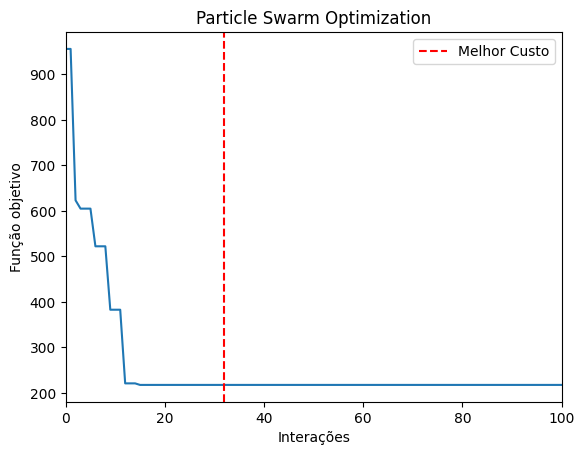


Cenário: quarto_cenario
Número total de iterações: 100
Número de Particulas: 100
Número de Dimensões: 24
Melhor Custo: R$ 217,46
Número de Iterações até o Melhor Custo: 33
Tempo de Convergência para a segunda etapa: 0.6803655624389648 segundos


In [463]:
# Plotar gráfico de densidade da otimização

plt.figure()
plt.plot(cost_history)



# Calcule o tempo total de convergência
convergence_time_second_stage = end_time_second_stage - start_time_second_stage

# Localizando o índice da melhor interação
index_melhor_custo = cost_history.index(min(cost_history))

# Plotando a linha vertical
plt.axvline(index_melhor_custo, color='red', linestyle='--', label='Melhor Custo')


plt.xlabel('Interações')
plt.xlim(0, max_iterations)
plt.ylabel('Função objetivo')
# plt.ylim(0, 1500)
plt.title('Particle Swarm Optimization')
plt.legend()
plt.show()

print("")
print('Cenário:', CENARIO)
print("Número total de iterações:", max_iterations)
print("Número de Particulas:", num_particles)
print("Número de Dimensões:", dimensions)
print("Melhor Custo:", melhorCusto)
print("Número de Iterações até o Melhor Custo:", numero_interacoes)
print("Tempo de Convergência para a segunda etapa:", convergence_time_second_stage, "segundos")

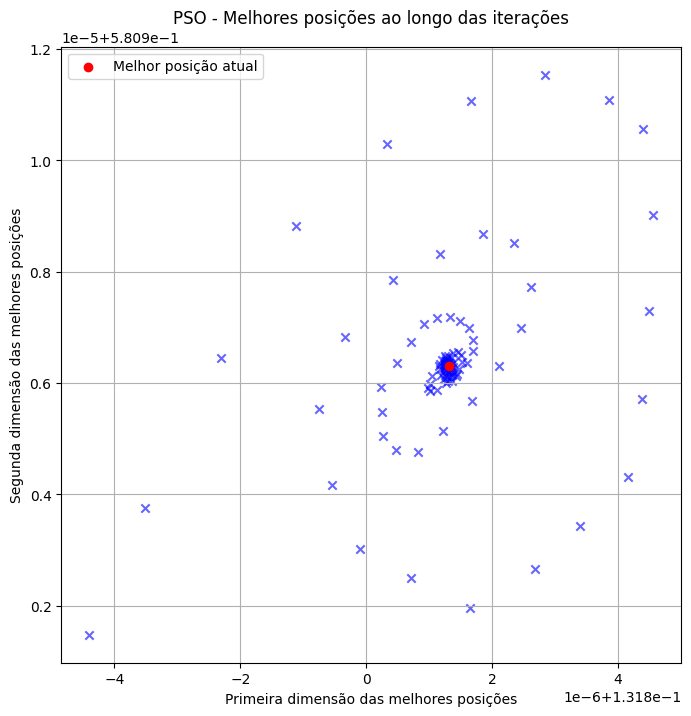

In [464]:
# Plotar o gráfico 3D com todas as melhores posições
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

# Plotar todas as melhores posições anteriores
for i in range(best_positions.shape[0]):
    ax.scatter(best_positions[i, 0], best_positions[i, 1], marker='x', c='blue', alpha=0.6)

# Plotar a última melhor posição com uma cor diferente para destacá-la
ax.scatter(best_positions[-1, 0], best_positions[-1, 1], c='red', label='Melhor posição atual')

ax.set_title('PSO - Melhores posições ao longo das iterações')
ax.set_xlabel('Primeira dimensão das melhores posições')
ax.set_ylabel('Segunda dimensão das melhores posições')
ax.legend()
plt.grid()
plt.show()

In [465]:
# Nome do arquivo CSV para salvar o resultado do melhor custo
nome_arquivo = f'{LINK_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_PRINCIPAL}.csv'

In [466]:
print(nome_arquivo)

/content/drive/MyDrive/datasets/resultados_optimizacao/resultados_pso/Resultados_quarto_cenario/melhor_custo_pso_quarto_cenario.csv


In [467]:
# # Adicionar o melhor custo atual à lista de melhores custos anteriores
# melhores_custos_anteriores = []
# try:
#     with open(nome_arquivo, 'r') as arquivo_csv:
#         reader = csv.reader(arquivo_csv)
#         next(reader)  # Pule o cabeçalho
#         for linha in reader:
#             melhores_custos_anteriores.append(linha[1])
# except FileNotFoundError:
#     pass  # Arquivo não existe, pode ser a primeira execução

# melhores_custos_anteriores.append(melhorCusto)  # Substitua pbest_cost[0] por best_cost

# # Criar uma lista com os valores atuais
# valores_atuais = [len(melhores_custos_anteriores), melhorCusto, convergence_time_second_stage,]

# # Abrir o arquivo CSV em modo de leitura e escrita e escrever os valores atuais no final do arquivo
# with open(nome_arquivo, 'a+', newline='') as arquivo_csv:
#     writer = csv.writer(arquivo_csv)

#     # Se o arquivo estiver vazio, escreva o cabeçalho
#     if arquivo_csv.tell() == 0:
#         writer.writerow(['Index', 'Melhor_Custo', 'Convergencia_Segunda_Etapa', 'Ciclos_MP'])

#     # Escrever os valores atuais
#     writer.writerow(valores_atuais)

In [468]:
# Leitura dos dados de tempo de falha para 4 cenarios de exemplo
resultado = pd.read_csv(nome_arquivo, sep=",")
resultado.head(10)

,Index,Melhor_Custo,Convergencia_Segunda_Etapa,Ciclos_MP
0,1,"R$ 211,89",1.272211,NaN
1,2,"R$ 214,67",1.161659,NaN


In [469]:
resultado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Index                       2 non-null      int64  
 1   Melhor_Custo                2 non-null      object 
 2   Convergencia_Segunda_Etapa  2 non-null      float64
 3   Ciclos_MP                   0 non-null      float64
dtypes: float64(2), int64(1), object(1)
memory usage: 192.0+ bytes


In [470]:
resultado.describe()

,Index,Convergencia_Segunda_Etapa,Ciclos_MP
count,2.000000,2.000000,0.0
mean,1.500000,1.216935,NaN
std,0.707107,0.078172,NaN
min,1.000000,1.161659,NaN
25%,1.250000,1.189297,NaN
50%,1.500000,1.216935,NaN
75%,1.750000,1.244573,NaN
max,2.000000,1.272211,NaN


In [471]:
param_segunda_etapa = ['Ciclos_MP', 'Melhor_Custo']
convergencia = ['Convergencia_Primeira_Etapa', 'Convergencia_Segunda_Etapa']
Melhor_Custo = ['Melhor_Custo']
Convergencia_Primeira_Etapa = ['Convergencia_Primeira_Etapa']
Convergencia_Segunda_Etapa = ['Convergencia_Segunda_Etapa']
Ciclos_MP = ['Ciclos_MP']

In [472]:
# # Cria uma grafico para os parameros da segunda etapa
# # Tamanho da figura
# plt.figure(figsize=(8, 5))

# # Itera sobre as colunas e cria um boxplot para cada uma
# for i, coluna in enumerate(param_segunda_etapa):
#     plt.subplot(1, 2, i + 1)  # 1 linhas, 3 colunas de gráficos
#     plt.boxplot(resultado[coluna])
#     plt.title(coluna)
#     plt.ylabel('Valores')

# # Ajusta o layout
# plt.tight_layout()
# plt.show()

In [473]:
# # Cria uma grafico para comparar as convervencias da primeira e segunda etapa
# # Tamanho da figura
# plt.figure(figsize=(8, 5))

# # Itera sobre as colunas e cria um boxplot para cada uma
# for i, coluna in enumerate(convergencia):
#     plt.subplot(1, 2, i + 1)  # 1 linhas, 2 colunas de gráficos
#     plt.boxplot(resultado[coluna])
#     plt.title(coluna)
#     plt.ylabel('Valores')

# # Ajusta o layout
# plt.tight_layout()
# plt.show()

In [474]:
# Arrays de tempos e severidade
Tempos = [
[[303]],
[[336]],
[[272]],
[[62]],
[[517]],
[[364]],
[[332]],
[[360]],
[[395]],
[[303]],
]

severidade = [
    [[0.5]],
[[0.5]],
[[0.5]],
[[0.5]],
[[0.5]],
[[0.5]],
[[0.5]],
[[0.5]],
[[0.5]],
[[0.5]],
]

# Verifica se ambos os arrays têm o mesmo número de linhas
if len(Tempos) == len(severidade):
    with open(f'{LINK_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_TEMPO_SEVERIDADE}.csv', "w") as file:
        file.write('Tempos_Manutencoes_Preventivas;Severidade_subsistema\n')
        for i in range(len(Tempos)):
            row = Tempos[i] + severidade[i]
            row_str = [str(value) for value in row]
            file.write(f"{i};{';'.join(row_str)}\n")
else:
    print("Os arrays têm números diferentes de linhas e não podem ser concatenados.")

In [475]:
# Leitura dos dados de tempo de falha para 4 cenarios de exemplo
dados = pd.read_csv(f'{LINK_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_TEMPO_SEVERIDADE}.csv', sep=";")
dados.head(10)

,Tempos_Manutencoes_Preventivas,Severidade_subsistema
0,[303],[0.5]
1,[336],[0.5]
2,[272],[0.5]
3,[62],[0.5]
4,[517],[0.5]
5,[364],[0.5]
6,[332],[0.5]
7,[360],[0.5]
8,[395],[0.5]
9,[303],[0.5]


In [476]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Tempos_Manutencoes_Preventivas  10 non-null     object
 1   Severidade_subsistema           10 non-null     object
dtypes: object(2)
memory usage: 240.0+ bytes


In [477]:
dados.describe()

,Tempos_Manutencoes_Preventivas,Severidade_subsistema
count,10,10
unique,9,1
top,[303],[0.5]
freq,2,10
